# CPN generator

In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
from collections import Counter 
import sklearn.cluster
import random

random.seed(0)

In [2]:
# data import
data = pd.read_excel(r'../data/Datos Codificados Estudio v2a.xlsx')
model = gensim.models.KeyedVectors.load_word2vec_format( 
    r'../Data/SBW-vectors-300-min5.bin', # using the spanish billion words embeddings
    binary=True # the model is in binary format
)

In [3]:
# Configuracion de spacy
nlp = spacy.load('es_core_news_sm')
# nlp.Defaults.stop_words.add("my_new_stopword")

## Funciones Importantes

In [4]:

def clean_text(text):
    """
    Recive a string and return the string in tokens without punctuations
    and in lowercase
    """
    # for each token in the sentence add to the list if is not a punctuation
    return [t for t in nlp(text.lower()) if not t.is_punct]


def normalize(tokens):
    """
    Recive al list of string and return in one string without stop words
    """
    # for each token if is not a stop word add the word to the list
    words = [t.orth_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(words))


def lematize(tokens):
    """
    Recive al list of string and return in one string without stop words 
    and Lematized
    """
    # for each token if is not a stop word add the lemma of the word in the list
    lemmas = [t.lemma_ for t in tokens if not t.is_stop]

    # return the tokens in one string
    return(" ".join(lemmas))

def to_vector(texto,model):
    """ 
    Receives a sentence string along with a word embedding model and 
    returns the vector representation of the sentence
    """
    tokens = texto.split() # splits the text by space and returns a list of words
    vec = np.zeros(300) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is both in the word embedding
            vec += model[word] # adds every word embedding to the vector
    return vec / np.linalg.norm(vec) # divides the vector by their normal


# Preprocesamiento de los datos

In [5]:
pd.options.mode.chained_assignment = None # Para evitar que se muestre warnings

# Normalizacion de los conceptos, descripciones y codificaciones
for i in range(len(data)):
    data['Descripción'][i] = normalize(clean_text(data['Descripción'][i]))

## Generación de Matriz de los datos

In [8]:
# Creation of the matrix to make the clustering process
descriptions_matrix = np.zeros( # creatign an empty matrix
    (
        len(data), # the number of data points
        len(model['hola']) # the number of components of the word embedding
    )
)

# matrix filling 
for i,description in enumerate(data['Descripción']):
    vector = to_vector(description,model)
    descriptions_matrix[i,] = vector

# Concatenate the matrix with the data of each observation
data_matrix = np.concatenate([descriptions_matrix,data], axis=1)

#--------------------------------------------------------------------------------------
# This is the important matrix
# Remove of the 'Nan' data
data_matrix_without_nan = data_matrix[~pd.isnull(data_matrix[:,:300]).any(axis=1)]
#--------------------------------------------------------------------------------------

# reduce the matrix to the importan
data_matrix_without_nan = np.concatenate(
    (data_matrix_without_nan[:,:300],                       # Vector of the description
    np.reshape(data_matrix_without_nan[:,302], (-1, 1)),    # Cue/Concept
    np.reshape(data_matrix_without_nan[:,306], (-1, 1)),    # Codification
    np.reshape(data_matrix_without_nan[:,303], (-1, 1))     # Description of the cue
    ),
    axis = 1
)

<ipython-input-4-89365e79bd8b>:42: RuntimeWarning: invalid value encountered in true_divide
  return vec / np.linalg.norm(vec) # divides the vector by their normal


## Testing random generations

In [18]:
# Generation of test-train data

from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

In [13]:
rand_acc = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        counter += test[i,301] == np.random.choice(train_codes)
    rand_acc.append(counter/len_test)

print(np.mean(rand_acc))
print(np.std(rand_acc))


0.0012545743104104092
0.0010250251045891628


In [19]:
rand_acc_top3 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top3.append(counter/len_test)

print(np.mean(rand_acc_top3))
print(np.std(rand_acc_top3))

0.003554080700235656
0.0022524367186731293


In [70]:
rand_acc_top5 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(5):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top5.append(counter/len_test)

print(np.mean(rand_acc_top5))
print(np.std(rand_acc_top5))

0.005225972027299397
0.0011458654681946521


In [75]:
rand_acc_top10 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(10):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top10.append(counter/len_test)

print(np.mean(rand_acc_top10))
print(np.std(rand_acc_top10))

0.009197369744188385
0.0019156108352290523


In [76]:
rand_acc_top50 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):
    
    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    train_codes=np.unique(train[:,301])

    len_test = len(test)
    counter = 0
    for i in range(len_test):
        for _ in range(50):
            val = test[i,301] == np.random.choice(train_codes)
            if val:
                counter += val
                break
    rand_acc_top50.append(counter/len_test)

print(np.mean(rand_acc_top50))
print(np.std(rand_acc_top50))

0.040133261630881024
0.00333791220889897


In [11]:
rand_concept_acc = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        counter += test[i,301] == np.random.choice(concept_cluster[test[i,300]])
    rand_concept_acc.append(counter/len_test)

print(np.mean(rand_concept_acc))
print(np.std(rand_concept_acc))


0.008152219059736013
0.001386527089724892


In [20]:
rand_concept_acc_top3 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top3.append(counter/len_test)

print(np.mean(rand_concept_acc_top3))
print(np.std(rand_concept_acc_top3))

0.030726468260734597
0.006755312892493112


In [77]:
rand_concept_acc_top5 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top5.append(counter/len_test)

print(np.mean(rand_concept_acc_top5))
print(np.std(rand_concept_acc_top5))

0.02800964485425602
0.002831222395939669


In [78]:
rand_concept_acc_top10 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top10.append(counter/len_test)

print(np.mean(rand_concept_acc_top10))
print(np.std(rand_concept_acc_top10))

0.02613007874153452
0.00458795305860302


In [79]:
rand_concept_acc_top50 = []
for train_index, test_index in kfold.split(data_matrix_without_nan):

    train = data_matrix_without_nan[train_index,:]
    test = data_matrix_without_nan[test_index,:]

    concept_cluster = {
                i:np.unique(train[:,301][train[:,300]==i]) for i in np.unique(train[:,300])
                }
    
    len_test = len(test)
    counter = 0
    
    for i in range(len_test):
        for _ in range(3):
            val = test[i,301] == np.random.choice(concept_cluster[test[i,300]])
            if val:
                counter += val
                break
    rand_concept_acc_top50.append(counter/len_test)

print(np.mean(rand_concept_acc_top50))
print(np.std(rand_concept_acc_top50))

0.029055669958858533
0.004151915381321839


## Model Creation

In [12]:
# Class creation
class PLT_processor:

    def __init__(self, method = 0, n_clusters = 500):
        """
        Recives the type of method to use, 
        - 0: Clasify using K-Means (Simple)
        - 1: Clasify to the codification with the same concept 
        """
        self.n_clusters = n_clusters
        self.method = method # Method of Processing the data
        self.KMeans_dict = {}
        self.KMeans_categories = {}

        if method == 1:
            self.inverse_concept_cluster = {}
            self.concept_cluster = {}

        self.topk = np.zeros((test.shape[0],500))

    def most_frequent(self, List): 
        """
        Recives a list of words, and return the word most frequente of
        the list
        """
        # ? Agregar la frase 'PENDIENTE' en caso de que haya multiples codificaciones con la misma frecuencia ?
        occurence_count = Counter(List) 
        return occurence_count.most_common(1)[0][0] 


    def model_train(self, train):
        """
        Recives the train dataset and the number of clusters to train 
        the k-means model
        """
        # creates de k-means object
        self.kemean = sklearn.cluster.KMeans(n_clusters=self.n_clusters, random_state=0)
        # Train the k-means algorithm
        self.kemean.fit(train[:,:300])

        # print(self.kemean.n_clusters)
        # Dataframe of train dataset
        df = pd.DataFrame(
            np.concatenate([
                np.reshape(train[:,301], (-1, 1)),          # Human codification
                np.reshape(self.kemean.labels_, (-1, 1)),   # Number of the KMean centroid
                np.reshape(train[:,300], (-1, 1))           # Concept of the codification
                ], axis=1), 
            columns=['Human', 'KMeans', 'Concept'])
        
        # create a dictionary of all the humans codifications for each Cluster
        self.KMeans_dict = df.groupby(by='KMeans')['Human'].apply(list).to_dict()

        # Fill a dictionary with the most frecuent value in the centroid
        for key, val in self.KMeans_dict.items():
            self.KMeans_categories[key] = self.most_frequent(val)
        
        # Generates the prediction for the train dataset
        df['KM_Prediction'] = df['KMeans'].map(self.KMeans_categories)

        if self.method == 1:
            # dictionary of the codifications that doesn't show in a concept
            self.not_concept_cluster = {
                i:[False if j in np.unique(df['KMeans'][df['Concept']==i]) else True for j in range(self.n_clusters)] 
                for i in np.unique(df['Concept'])
                }
            # dictionary of clusters for each concept
            self.concept_cluster = {
                i:np.unique(df['KMeans'][df['Concept']==i]) for i in np.unique(df['Concept'])
                }
        return self.kemean.inertia_

    
    def get_distances(self, test):
        """
        recives the test data to calculate the distances of each frase, return 
        a matrix with the distances sorted
        """

        # Distance matrix of each test point to each cluster center
        distance_matrix = np.zeros((test.shape[0],self.n_clusters))

        # for each cluster center
        for i in range(distance_matrix.shape[1]):    
            # Euclidian distance of each point to the i-est cluster center
            distance_matrix[:,i]=np.sqrt(np.sum((test[:,:300].astype(np.float)-self.kemean.cluster_centers_[i,:])**2,axis=1))

        if self.method == 1:
            # for each datapoint
            for i in range(distance_matrix.shape[0]):
                # if the centroid not share the same concept asing NaN value
                distance_matrix[i, self.not_concept_cluster[test[i,300]]] = np.nan
    

        # Sorting distances
        self.topk=np.argsort(distance_matrix,axis=1)

    
    def set_labels(self, test):
        """
        Create a new matrix from the clusters sorted and change the value
        from numeric to the string according the codification
        """

        # Change of the numeric value to the codification 
        self.topKS=pd.DataFrame(self.topk)

        # create a temporal array of the kmeans categories
        tempData = np.array([value for (_, value) in sorted(self.KMeans_categories.items())])
        
        # for each cluster center
        # print("Setting labels")
        # print('len temp',len(self.KMeans_categories))
        # print('dim topKS',self.topKS.shape[1])
        for j in range(self.topKS.shape[1]):
            # set the codification of the numeric value in the topk list
            self.topKS.iloc[:,j]=tempData[self.topk[:,j]]
        
        if self.method == 1:
            # for each datapoint
            for i in range(self.topKS.shape[0]):
                # Remove of the clusters that not share the same concept
                self.topKS.iloc[i, np.isin(self.topk[i,:], self.concept_cluster[test[i,300]] ,invert=True)]= np.nan


    def get_accuracies(self, test):
        """
        Recives the test matrix and return the accuracies of the 
        diferents predictions
        """
        #Creating the accuracy table to check each data point
        testLabel=np.zeros(self.topKS.shape)
        indexes_method0=pd.DataFrame(np.zeros((self.topKS.shape[0],2)), columns=['index', 'value']) 

        #For each data point
        for i in range(testLabel.shape[0]):
            #Checking if some of the cluster is able to classify it right
            boolClass=self.topKS.iloc[i,:]==test[i,301]
            if sum(boolClass)>0:
                getIndex=boolClass.idxmax()
                indexes_method0.iloc[i,0] = getIndex
                indexes_method0.iloc[i,1] = self.topKS.iloc[i,getIndex]
                #Setting the rest of the data point as 1
                testLabel[i,getIndex:]=1
            else:
                indexes_method0.iloc[i,0] = np.nan
                indexes_method0.iloc[i,1] = np.nan
        accuracies=testLabel.sum(axis=0)/testLabel.shape[0]

        return accuracies

    def process(self, train, test):
        self.model_train(train)
        self.get_distances(test)
        self.set_labels(test)
        return self.get_accuracies(test)


In [13]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method0_acc = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    method0_acc[i] = acc[0]
    i+=1

print(method0_acc.mean())
print(method0_acc.std())

0.35744197129278643
0.006667009195196009


0.37520865850832663
0.008341383764169614


In [14]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method0_acc_top3 = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    method0_acc_top3[i] = acc[2]
    i+=1

print(method0_acc_top3.mean())
print(method0_acc_top3.std())

0.4163925359495984
0.01689698143216913


In [22]:
print(method0_acc_top3.mean())
print(method0_acc_top3.std())

0.4435657979302475
0.01534055305781037


In [15]:
# K = 500
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k500_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k500_acc_top[i,j] = acc[tops[j]]

    i+=1

In [16]:
print(k500_acc_top.mean(axis=0))
print(k500_acc_top.std(axis=0))

[0.35744197 0.41639254 0.44022289 0.47429292 0.5376298 ]
[0.00666701 0.01689698 0.01670659 0.01570128 0.01607529]


In [17]:
# K = 1000
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k1000_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, n_clusters=1000)
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k1000_acc_top[i,j] = acc[tops[j]]

    i+=1

In [18]:
print(k1000_acc_top.mean(axis=0))
print(k1000_acc_top.std(axis=0))

[0.39674257 0.46572623 0.48976491 0.52362814 0.59929609]
[0.01527219 0.02546635 0.02393099 0.02477833 0.02602777]


In [19]:
# K = 3827
# Top 1, 3, 5, 10, 50
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)
k3950_acc_top = np.zeros((5, 5))

tops=(0,2,4,9,49)

i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(0, n_clusters=len(train_index))
    acc = proc.process(train, test)

    for j in range(len(tops)):
        k3950_acc_top[i,j] = acc[tops[j]]

    i+=1

<ipython-input-12-a4d4d692bbea>:39: ConvergenceWarning: Number of distinct clusters (2978) found smaller than n_clusters (3827). Possibly due to duplicate points in X.
  self.kemean.fit(train[:,:300])


IndexError: index 3161 is out of bounds for axis 0 with size 2978

In [ ]:
print(k3950_acc_top.mean(axis=0))
print(k3950_acc_top.std(axis=0))

In [29]:
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5)

method1_acc = np.zeros(5)
i=0

for train_index, test_index in kfold.split(data_matrix_without_nan):
    train = data_matrix_without_nan[train_index, :]
    test = data_matrix_without_nan[test_index, :]

    proc = PLT_processor(1)
    acc = proc.process(train, test)

    method1_acc[i] = acc[0]
    i+=1

In [30]:
print(method1_acc.mean())
print(method1_acc.std())

0.33486553604141256
0.012014748371481811


# Busqueda del K optimo

In [13]:
from sklearn.model_selection import KFold
rango = range(25,1301,25)
k_inertia = np.zeros(len(rango))
j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    temp = np.zeros(5)
    i=0
    for train_index, test_index in kfold.split(data_matrix_without_nan):
        train = data_matrix_without_nan[train_index, :]
        test = data_matrix_without_nan[test_index, :]

        proc = PLT_processor(0, k)
        inertia = proc.model_train(train)

        temp[i] = inertia
        i+=1
    k_inertia[j] = temp.mean()
    j+=1
    

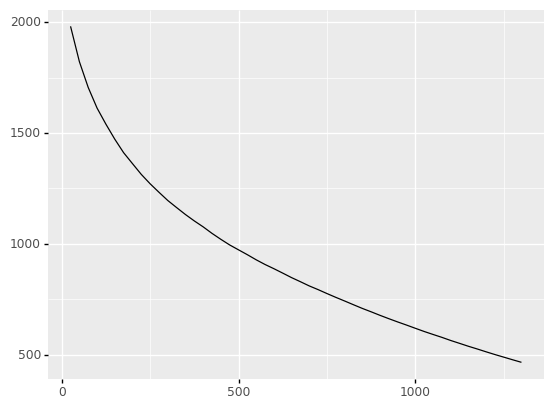

<ggplot: (202949055540)>

In [14]:
from plotnine import *

(ggplot()+aes(x=rango, y=k_inertia)+geom_line())

In [16]:
from sklearn.model_selection import KFold
rango = range(25,1301,25)
k_acc = np.zeros(len(rango))
j = 0
for k in rango:
    kfold=KFold(n_splits=5)

    temp = np.zeros(5)
    i=0
    for train_index, test_index in kfold.split(data_matrix_without_nan):
        train = data_matrix_without_nan[train_index, :]
        test = data_matrix_without_nan[test_index, :]

        proc = PLT_processor(0, k)
        acc = proc.process(train, test)

        temp[i] = acc[0]
        i+=1
    k_acc[j] = temp.mean()
    j+=1

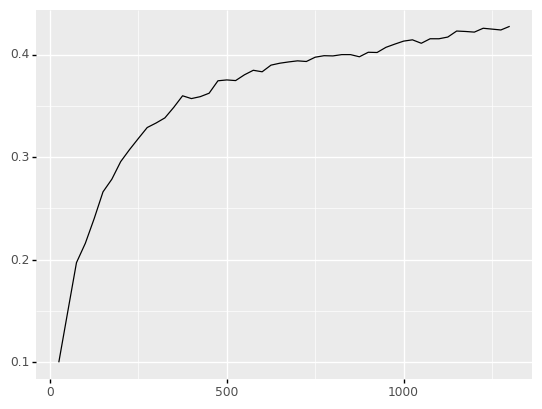

<ggplot: (202949055726)>

In [17]:
(ggplot()+aes(x=rango, y=k_acc)+geom_line())